In [1]:
#Desabilita logs e mantém apenas logs críticos (para evitar o libcuda ficar me avisando que a GPU tá funcionando)
%config Completer.use_jedi = False
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


In [110]:
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import scipy as spy
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
df = pd.read_csv('datasets/winequality-white.csv')

Esse dataset já está tratado e não tem valores N/A:

In [3]:
pd.isna(df).sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

E todos os valores já estão como float, fora a qualidade que está como valor inteiro:

In [4]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Podemos ver abaixo que existem muitos outliers, não só nessa coluna, mas em várias outras.Vou tentar usar um método para remover os outliers dessa, depois tento remover os das restantes com o mesmo método.
<b>Neste método, os outliers são definidos como os parâmetros que estão 3 desvios padrões acima da média. </b>

Este método seria um método de under-sampling, como é colocado no artigo do qual retiramos o dataset.

In [5]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

Nos boxplots fica mais fácil de visualizar esses outliers:

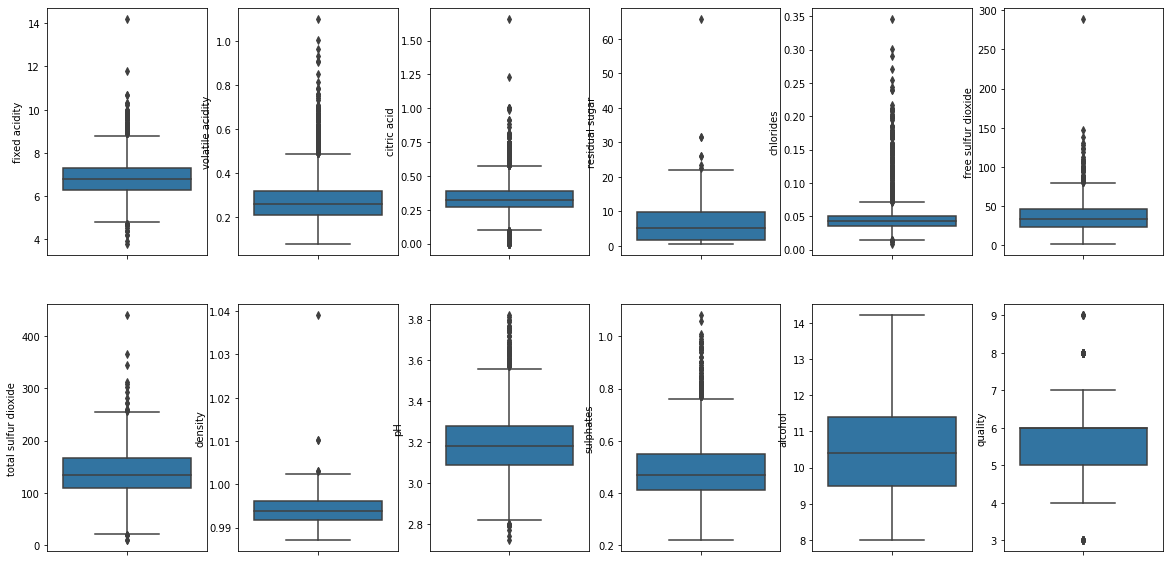

In [6]:
fig,ax = plt.subplots(ncols=6,nrows=2,figsize=(20,10))
index=0
ax=ax.flatten()

for col, value in df.items():
    if col!='type':
        sb.boxplot(y=col,data=df,ax=ax[index])
        index+=1

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

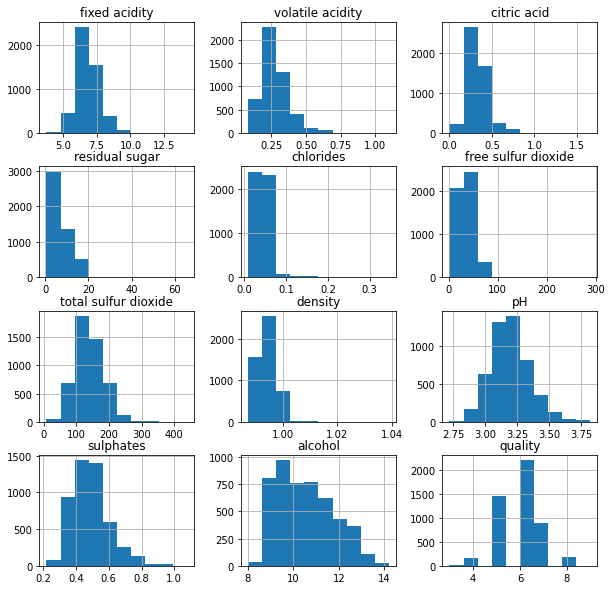

In [7]:
df.hist(figsize = (10, 10))

Abaixo, vamos remover todos os valores que estão acima de 3 desvios padrões da média.

In [8]:
cols = list(df.columns)
zscores = spy.stats.zscore(df[cols], nan_policy='omit')
abs_zscores = np.abs(zscores)
filtered_entries = (abs_zscores < 3).all(axis=1)
new_df = df[filtered_entries]
df = new_df

Feito esse método de under-sampling, vemos que no dataset as distribuições estão muito mais próximas de distribuições normais. E temos muito menos outliers nos boxplots abaixo:

In [9]:
df['quality'].value_counts()

6    2038
5    1309
7     855
8     161
4     124
Name: quality, dtype: int64

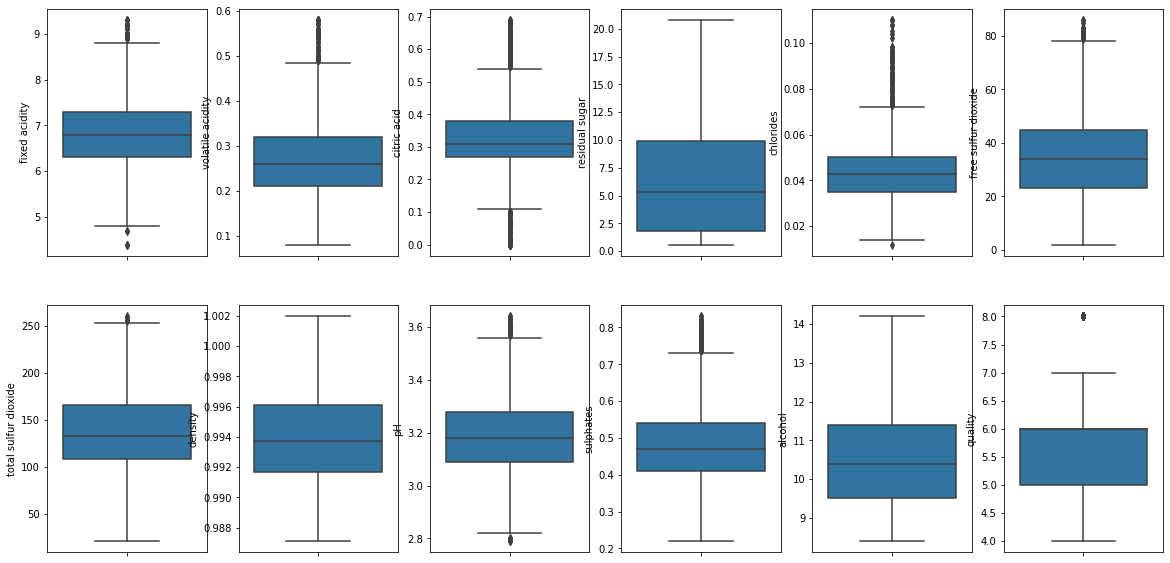

In [10]:
fig,ax = plt.subplots(ncols=6,nrows=2,figsize=(20,10))
index=0
ax=ax.flatten()

for col, value in df.items():
    if col!='type':
        sb.boxplot(y=col,data=df,ax=ax[index])
        index+=1

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

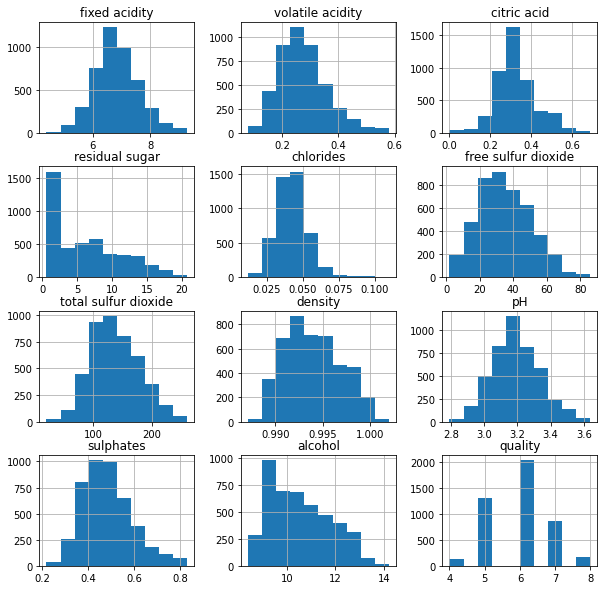

In [11]:
df.hist(figsize = (10, 10))

Mapa de calor

<AxesSubplot:>

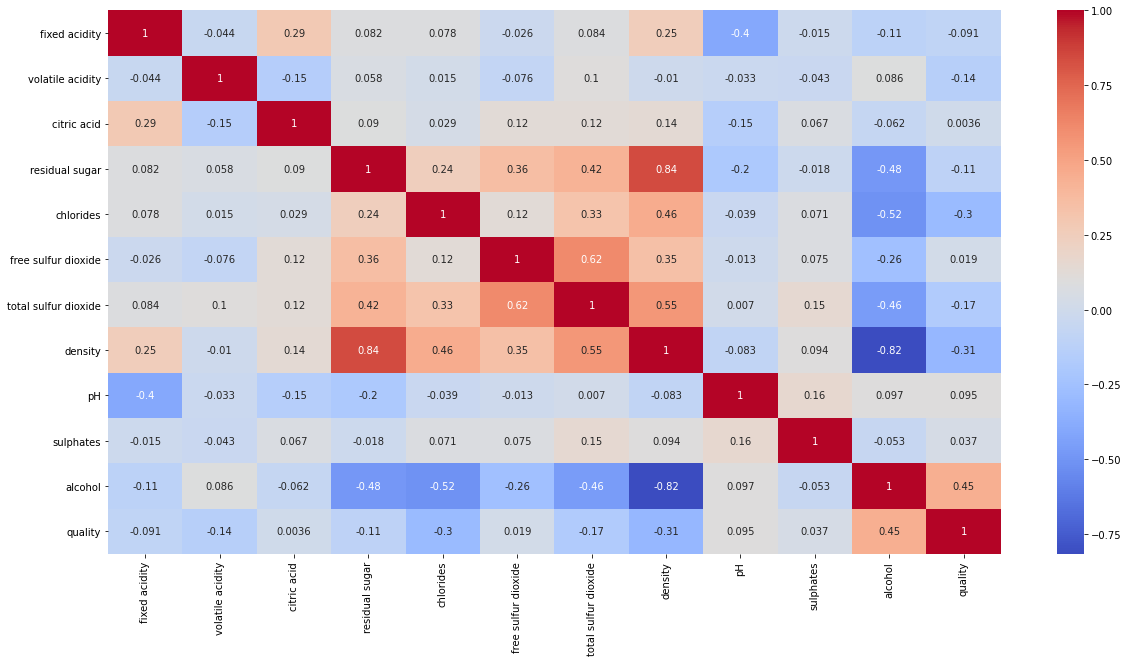

In [12]:
corr=df.corr()
plt.figure(figsize=(20,10))
sb.heatmap(corr,annot=True, cmap='coolwarm')

Ainda vou tratar os dados de qualidade para serem entre 0, 1 e 2:

In [13]:
df.loc[df['quality'] ==3, 'quality'] = 0
df.loc[df['quality'] ==4, 'quality'] = 0
df.loc[df['quality'] ==5, 'quality'] = 1
df.loc[df['quality'] ==6, 'quality'] = 1
df.loc[df['quality'] ==7, 'quality'] = 1
df.loc[df['quality'] ==8, 'quality'] = 2
df.loc[df['quality'] ==9, 'quality'] = 2
df['quality'].value_counts()
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        1  
1      9.5        1  
2     10.1        1  
3      9.9        1  
4      9.9        1

Ainda temos que fazer o one-hot encoding para que a rede neural consiga prever adequadamente

In [14]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['quality'])
df = one_hot_encoded_data.rename(columns={'quality_0': 'baixa', 'quality_1': 'media', 'quality_2': 'alta'})
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  baixa  media  alta  
0      8.8      0      1     0  
1      9.5      0      1     0  
2     10.1      0      1     0  
3      9.9      0      1     0  
4      9.9      0      1     0

<h2>Separando o dataset em dados de treinamento e teste </h2>

In [78]:
X =  df.drop(columns=["baixa", "media", "alta"], axis=1)
y=  df[['baixa','media','alta']]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3589, 11)
(898, 11)
(3589, 3)
(898, 3)


<h1>Treinamento do dataset </h1>

In [124]:
dimension = X_train.shape[1]
from keras import backend as K
def create_model():
    model = Sequential()
    model.add(layers.Dense(10, input_dim=dimension, activation='relu'))
    model.add(layers.Dense(10, input_dim=dimension, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 263
Trainable params: 263
Non-trainable params: 0
_________________________________________________________________


In [125]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=10)

Epoch 1/20
359/359 [==============================] - 0s 753us/step - loss: 0.7811 - accuracy: 0.8927 - val_loss: 0.3621 - val_accuracy: 0.9343
Epoch 2/20
359/359 [==============================] - 0s 526us/step - loss: 0.4235 - accuracy: 0.9184 - val_loss: 0.3109 - val_accuracy: 0.9432
Epoch 3/20
359/359 [==============================] - 0s 531us/step - loss: 0.3568 - accuracy: 0.9250 - val_loss: 0.2754 - val_accuracy: 0.9421
Epoch 4/20
359/359 [==============================] - 0s 555us/step - loss: 0.3202 - accuracy: 0.9329 - val_loss: 0.2738 - val_accuracy: 0.9454
Epoch 5/20
359/359 [==============================] - 0s 545us/step - loss: 0.3168 - accuracy: 0.9326 - val_loss: 0.2702 - val_accuracy: 0.9443
Epoch 6/20
359/359 [==============================] - 0s 533us/step - loss: 0.3111 - accuracy: 0.9342 - val_loss: 0.3140 - val_accuracy: 0.9454
Epoch 7/20
359/359 [==============================] - 0s 537us/step - loss: 0.3199 - accuracy: 0.9334 - val_loss: 0.3272 - val_accuracy:

<h1> Avaliação do resultado </h1>

Convertemos as probabilidades que foram retornadas para o máximo do array:

In [126]:
y_pred = model.predict(X_test)
def max_probs(array):
    parsed_pred = np.empty((0,3))
    for idx, x in enumerate(array):
        idx_max = x.argmax()
        x = np.zeros((3,))
        x[idx_max] = 1
        array[idx] = x
max_probs(y_pred)
y_pred

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

Para criar a matriz de confusão vamos converter novamente para as categorias 0 1 e 2 após a predição:

In [127]:
def to_category(array):
    categories = []
    for idx, x in enumerate(array):
        idx_max = x.argmax()
        x = 0
        if idx_max == 0: x = 0
        if idx_max == 1: x = 1
        if idx_max == 2: x = 2
        categories.append(x)
    return categories


categorical_y_pred = to_category(y_pred)
categorical_y_test = to_category(y_test.to_numpy())

In [128]:
data = confusion_matrix(categorical_y_test, categorical_y_pred)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

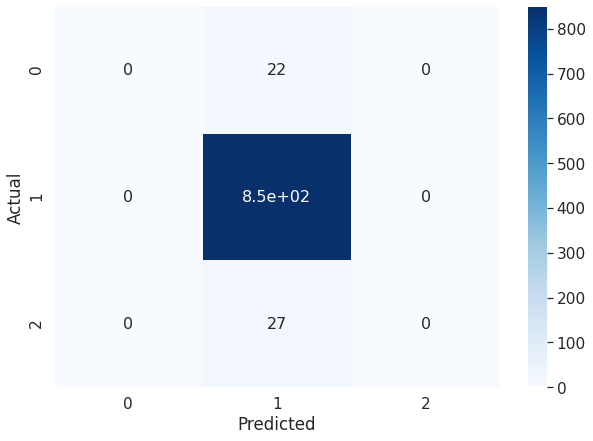

In [129]:
df_cm = pd.DataFrame(data, columns=np.unique(categorical_y_test), index = np.unique(categorical_y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sb.set(font_scale=1.4)#for label size
sb.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size